In [1]:
import os
import json
import cv2
import numpy as np
import pandas as pd
from skimage.color import label2rgb
import random
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models
import tensorflow.keras.backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model


In [2]:
def load_images_and_masks(image_paths, json_paths, image_size=(256, 256), point_size=3):
    images = []
    masks = []

    for img_path, json_path in zip(image_paths, json_paths):
        img = cv2.imread(img_path)
        img = img / 255
        original_size = img.shape[:2] 
        img = cv2.resize(img, image_size)
        images.append(img)

       
        mask = np.zeros((image_size[0], image_size[1], 4), dtype=np.uint8)
        mask[:, :, 0] = 1 

        try:
            with open(json_path, 'r') as f:
                json_data = json.load(f)
        except Exception as e:
            print(f"Błąd odczytu JSON {json_path}: {e}")
            continue  

        if not isinstance(json_data, list):
            print(f"Nieprawidłowy format JSON w {json_path}, oczekiwano listy!")
            continue

        for item in json_data:
            if 'x' in item and 'y' in item and 'label_id' in item:
                x, y, label = int(item['x']), int(item['y']), int(item['label_id'])

                x = int((x / original_size[1]) * image_size[1])
                y = int((y / original_size[0]) * image_size[0])

                if 0 <= x < image_size[1] and 0 <= y < image_size[0]: 
                    if label == 1:
                        cv2.circle(mask, (x, y), point_size, (0, 1, 0, 0), -1)  
                    elif label == 2:
                        cv2.circle(mask, (x, y), point_size, (0, 0, 1, 0), -1)  
                    elif label == 3:
                        cv2.circle(mask, (x, y), point_size, (0, 0, 0, 1), -1)  

        
        mask[:, :, 0] = (np.sum(mask[:, :, 1:], axis=-1) == 0).astype(np.uint8)

        masks.append(mask)

    return np.array(images), np.array(masks, dtype=np.float32)


def load_files(path):
    images = []
    jsons = []
    for root, _, files in os.walk(path):
        for file in files:
            if file.endswith(('.jpg', '.png')):
                images.append(os.path.join(root, file))
            elif file.endswith('.json'):
                jsons.append(os.path.join(root, file))
    return images, jsons

In [3]:
def conv_block(x, filters):
    x = layers.Conv2D(filters, (3, 3), activation='relu', padding='same')(x)
    x = layers.Conv2D(filters, (3, 3), activation='relu', padding='same')(x)
    return x

def max_pool(x):
    return layers.MaxPooling2D((2, 2))(x)

def upsample_block(x, skip, filters):
    x = layers.UpSampling2D((2, 2))(x)
    x = layers.Conv2D(filters, (2, 2), activation='relu', padding='same')(x)
    x = layers.concatenate([x, skip])
    x = conv_block(x, filters)
    return x


In [4]:
def unet(input_shape=(256, 256, 3), output_channels=4, filterd_vector=[32, 64, 128, 256, 512]):
    inputs = layers.Input(input_shape)

    conv1 = conv_block(inputs, filterd_vector[0])
    pool1 = max_pool(conv1)

    conv2 = conv_block(pool1, filterd_vector[1])
    pool2 = max_pool(conv2)

    conv3 = conv_block(pool2, filterd_vector[2])
    pool3 = max_pool(conv3)

    conv4 = conv_block(pool3, filterd_vector[3])
    pool4 = max_pool(conv4)

    conv5 = conv_block(pool4, filterd_vector[4])

    up6 = upsample_block(conv5, conv4, filterd_vector[3])
    up7 = upsample_block(up6, conv3, filterd_vector[2])
    up8 = upsample_block(up7, conv2, filterd_vector[1])
    up9 = upsample_block(up8, conv1, filterd_vector[0])

    outputs = layers.Conv2D(output_channels, (1, 1), activation='softmax')(up9)

    model = models.Model(inputs, outputs)
    return model

In [5]:
train_images_paths, train_json = load_files('SHIDC-B-Ki-67/bare images/Train')
test_images_paths, test_json = load_files('SHIDC-B-Ki-67/bare images/Test')
X_train, Y_train = load_images_and_masks(train_images_paths, train_json)
X_test, Y_test = load_images_and_masks(test_images_paths, test_json)
X_train_final, X_val, Y_train_final, Y_val = train_test_split(
    X_train, Y_train, test_size=0.2, random_state=42
)

print(f"Dane treningowe: obrazy {X_train.shape}, maski {Y_train.shape}")
print(f"Dane testowe: obrazy {X_test.shape}, maski {Y_test.shape}")



Dane treningowe: obrazy (1656, 256, 256, 3), maski (1656, 256, 256, 4)
Dane testowe: obrazy (700, 256, 256, 3), maski (700, 256, 256, 4)


In [6]:
model_dir = "best_model"
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

In [7]:
def weighted_categorical_crossentropy(weights):
    weights = K.variable(weights)
    
    def loss(y_true, y_pred):
        y_pred /= K.sum(y_pred, axis=-1, keepdims=True)
        y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())
        loss = y_true * K.log(y_pred) * weights
        return -K.sum(loss, -1)
    
    return loss


class_weights = [0.25, 0.8, 0.75, 4.5]
loss_fn = weighted_categorical_crossentropy(class_weights)

In [10]:
pred_mask_dir = "predicted_masks"
if not os.path.exists(pred_mask_dir):
    os.makedirs(pred_mask_dir)

In [14]:
model = unet(output_channels=4)
model.compile(
    optimizer=Adam(learning_rate=0.00001),
    loss=loss_fn, 
    metrics=['accuracy']
)

checkpoint = ModelCheckpoint(
    filepath=os.path.join(model_dir, "unet_best_model.h5"),  
    monitor="val_loss",  
    save_best_only=True,  
    mode="min",  
    verbose=0
)

early_stopping = EarlyStopping(
    monitor="val_loss",  
    patience=5, 
    restore_best_weights=True,  
    verbose=1
)

history = model.fit(
    X_train_final, Y_train_final,
    epochs=100, batch_size=24,
    validation_data=(X_val, Y_val),
    callbacks=[checkpoint, early_stopping]
)

K.clear_session() 

Epoch 1/100
56/56 [==============================] - 40s 466ms/step - loss: 0.3656 - accuracy: 0.4648 - val_loss: 0.3447 - val_accuracy: 0.9623
Epoch 2/100
56/56 [==============================] - 21s 373ms/step - loss: 0.2660 - accuracy: 0.9658 - val_loss: 0.1487 - val_accuracy: 0.9712
Epoch 3/100
56/56 [==============================] - 21s 373ms/step - loss: 0.1293 - accuracy: 0.9695 - val_loss: 0.1147 - val_accuracy: 0.9713
Epoch 4/100
56/56 [==============================] - 21s 373ms/step - loss: 0.1168 - accuracy: 0.9696 - val_loss: 0.1095 - val_accuracy: 0.9713
Epoch 5/100
56/56 [==============================] - 21s 374ms/step - loss: 0.1137 - accuracy: 0.9696 - val_loss: 0.1075 - val_accuracy: 0.9713
Epoch 6/100
56/56 [==============================] - 21s 374ms/step - loss: 0.1121 - accuracy: 0.9696 - val_loss: 0.1059 - val_accuracy: 0.9713
Epoch 7/100
56/56 [==============================] - 21s 367ms/step - loss: 0.1115 - accuracy: 0.9696 - val_loss: 0.1059 - val_accuracy:

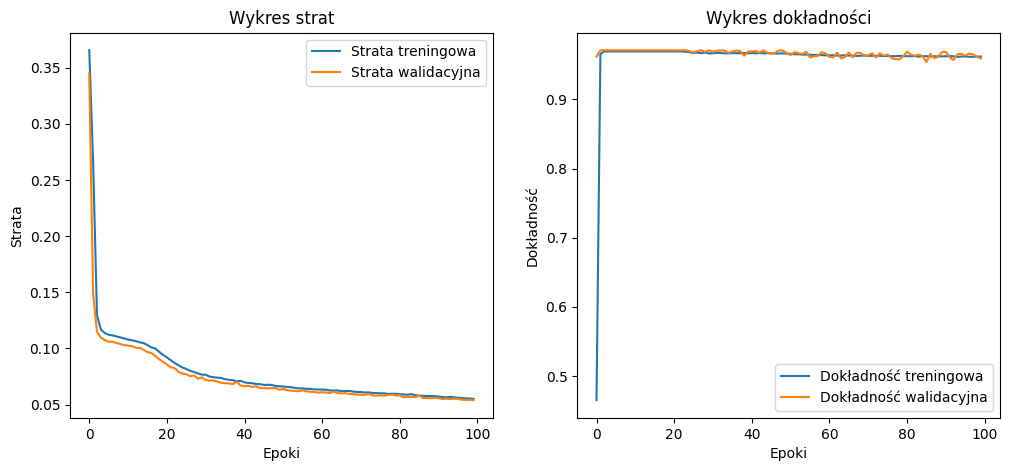

In [15]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Strata treningowa')
plt.plot(history.history['val_loss'], label='Strata walidacyjna')
plt.xlabel('Epoki')
plt.ylabel('Strata')
plt.title('Wykres strat')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Dokładność treningowa')
plt.plot(history.history['val_accuracy'], label='Dokładność walidacyjna')
plt.xlabel('Epoki')
plt.ylabel('Dokładność')
plt.title('Wykres dokładności')
plt.legend()

plt.show()

1/1 [==============================] - 1s 900ms/step


Text(0.5, 1.0, 'Prawdziwa maska')

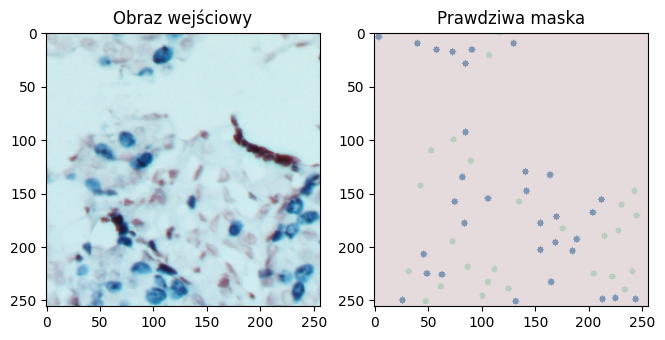

In [16]:
idx = random.randint(0, len(X_test) - 1)
test_img = X_test[idx:idx+1]  
true_mask = Y_test[idx] 
pred_mask = model.predict(test_img)[0]
plt.figure(figsize=(12, 5))
plt.subplot(1, 3, 1)
plt.imshow(test_img[0])
plt.title("Obraz wejściowy")
plt.subplot(1, 3, 2)
plt.imshow(true_mask[:, :, 0], cmap='Reds', alpha=0.5) 
plt.imshow(true_mask[:, :, 1], cmap='Greens', alpha=0.5)
plt.imshow(true_mask[:, :, 2], cmap='Blues', alpha=0.5)  
plt.title("Prawdziwa maska")


1/1 [==============================] - 0s 15ms/step


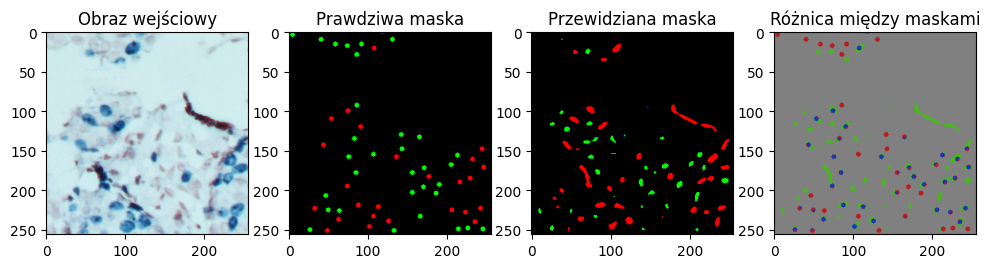

In [17]:
import random
import os
import cv2
import numpy as np
from skimage.color import label2rgb
import matplotlib.pyplot as plt

custom_colors = {
    0: [0, 0, 0],  # Tło - czarny
    1: [255, 0, 0], # Pozytywne - czerwony
    2: [0, 255, 0], # Negatywne - zielony
    3: [0, 0, 255]  # TIL - niebieski 
}

def compute_mask_difference(true_mask, pred_mask):
    diff_mask = np.zeros((*true_mask.shape, 3), dtype=np.uint8)

    true_mask_bin = (true_mask > 0).astype(np.uint8)
    pred_mask_bin = (pred_mask > 0).astype(np.uint8)

    # False Positives – Model przewidział, ale nie ma w ground truth (Zielony)
    diff_mask[(true_mask_bin == 0) & (pred_mask_bin == 1)] = [71, 183, 29]

    # False Negatives – Model nie przewidział, ale ground truth istnieje (Czerwony)
    diff_mask[(true_mask_bin == 1) & (pred_mask_bin == 0)] = [183, 29, 29]

    # True Positives – Model dobrze przewidział (Niebieski)
    diff_mask[(true_mask_bin == 1) & (pred_mask_bin == 1)] = [29, 50, 183]

    # Tło – jeśli żaden z warunków nie został spełniony, ustaw szary kolor
    diff_mask[(true_mask_bin == 0) & (pred_mask_bin == 0)] = [128, 128, 128]

    return diff_mask

def apply_custom_colors(mask, colors):
    colored_mask = np.zeros((*mask.shape, 3), dtype=np.uint8)
    for label, color in colors.items():
        colored_mask[mask == label] = color
    return colored_mask


test_img = X_test[idx:idx+1]  
true_mask = np.argmax(Y_test[idx], axis=-1)
pred_mask = np.argmax(model.predict(test_img)[0], axis=-1)


true_mask_colored = apply_custom_colors(true_mask, custom_colors)
pred_mask_colored = apply_custom_colors(pred_mask, custom_colors)
mask_diff_colored = compute_mask_difference(true_mask, pred_mask)

plt.figure(figsize=(12, 5))

plt.subplot(1, 4, 1)
plt.imshow(test_img[0])
plt.title("Obraz wejściowy")

plt.subplot(1, 4, 2)
plt.imshow(true_mask_colored)
plt.title("Prawdziwa maska")

plt.subplot(1, 4, 3)
plt.imshow(pred_mask_colored)
plt.title("Przewidziana maska")

plt.subplot(1, 4, 4)
plt.imshow(mask_diff_colored)
plt.title("Różnica między maskami")
plt.show()


In [18]:
def test_model_performance(model, X_test, Y_test):

    Y_pred = model.predict(X_test)

    Y_pred_labels = np.argmax(Y_pred, axis=-1)  
    Y_test_labels = np.argmax(Y_test, axis=-1) 

    num_classes = Y_test.shape[-1]
    class_names = ["Tło", "Pozytywne", "Negatywne", "TIL" ]
    if num_classes != len(class_names):
        class_names = [f"Klasa {i}" for i in range(num_classes)]

    iou_scores = []
    for class_idx in range(num_classes):
        intersection = np.logical_and(Y_test_labels == class_idx, Y_pred_labels == class_idx).sum()
        union = np.logical_or(Y_test_labels == class_idx, Y_pred_labels == class_idx).sum()
        iou = intersection / union if union > 0 else 0
        iou_scores.append(iou)

    correct_classifications = np.sum(Y_test_labels == Y_pred_labels)
    total_pixels = np.prod(Y_test_labels.shape)
    classification_accuracy = correct_classifications / total_pixels

    print("\nWyniki modelu na zbiorze testowym:")
    for i, class_name in enumerate(class_names):
        print(f"{class_name}: IoU = {iou_scores[i] * 100:.2f}%")

    print(f"\nOgólna dokładność klasyfikacji: {classification_accuracy * 100:.2f}%")

    return iou_scores, classification_accuracy

my_model = load_model("./best_model/2_unet_best_model.h5")
iou_results, accuracy = test_model_performance(my_model, X_test, Y_test)


22/22 [==============================] - 11s 316ms/step

Wyniki modelu na zbiorze testowym:
Tło: IoU = 97.05%
Pozytywne: IoU = 20.13%
Negatywne: IoU = 5.80%
TIL: IoU = 0.00%

Ogólna dokładność klasyfikacji: 97.05%


In [19]:
from skimage.measure import label, regionprops
from scipy.optimize import linear_sum_assignment
import numpy as np

def calculate_iou_objects(true_mask, pred_mask, iou_threshold=0.3):
    results = {
        "IoU": {},
        "Detected Cells": {},
        "False Positives": {},
        "False Negatives": {},
        "True Positives": {},
        "Cost Matrix": {}, 
        "Hungarian Matches": {} 
    }

    unique_classes = np.unique(true_mask)
    unique_classes = unique_classes[unique_classes > 0]

    for class_id in unique_classes:
        true_class_mask = (true_mask == class_id).astype(np.uint8)
        pred_class_mask = (pred_mask == class_id).astype(np.uint8)

        true_labeled = label(true_class_mask)  
        pred_labeled = label(pred_class_mask) 

        true_regions = regionprops(true_labeled)
        pred_regions = regionprops(pred_labeled)

        total_true_cells = len(true_regions)  
        total_pred_cells = len(pred_regions) 

        matched_cells = 0
        false_positives = 0
        false_negatives = total_true_cells  
        intersection = 0
        union = 0

        if total_true_cells > 0 and total_pred_cells > 0:
            cost_matrix = np.ones((total_true_cells, total_pred_cells))  

            for i, true_region in enumerate(true_regions):
                true_single_cell = (true_labeled == true_region.label)

                for j, pred_region in enumerate(pred_regions):
                    pred_single_cell = (pred_labeled == pred_region.label)

                    # Tworzenie macierzy kosztów
                    inter = np.logical_and(true_single_cell, pred_single_cell).sum()
                    uni = np.logical_or(true_single_cell, pred_single_cell).sum()
                    iou = inter / uni if uni > 0 else 0

                    # Tylko jeśli IoU >= próg – w przeciwnym razie koszt = 1
                    if iou >= iou_threshold:
                        cost_matrix[i, j] = 1 - iou

            # Algorytm węgierski optymalizuje dopasowania między komórkami, minimalizując koszty
            row_ind, col_ind = linear_sum_assignment(cost_matrix)

            for i, j in zip(row_ind, col_ind):
                actual_iou = 1 - cost_matrix[i, j]
                if actual_iou >= iou_threshold:
                    matched_cells += 1
                    true_single_cell = (true_labeled == true_regions[i].label)
                    pred_single_cell = (pred_labeled == pred_regions[j].label)

                    inter = np.logical_and(true_single_cell, pred_single_cell).sum()
                    uni = np.logical_or(true_single_cell, pred_single_cell).sum()

                    intersection += inter
                    union += uni
                    false_negatives -= 1

            false_positives = total_pred_cells - matched_cells

            results["Cost Matrix"][class_id] = cost_matrix.tolist()
            results["Hungarian Matches"][class_id] = list(zip(row_ind.tolist(), col_ind.tolist()))
        else:
            results["Cost Matrix"][class_id] = []
            results["Hungarian Matches"][class_id] = []

        iou = (intersection / union) * 100 if union > 0 else 0
        results["IoU"][class_id] = round(iou, 2)
        results["Detected Cells"][class_id] = matched_cells
        results["False Positives"][class_id] = false_positives
        results["False Negatives"][class_id] = false_negatives
        results["True Positives"][class_id] = matched_cells

    return results


In [20]:
def calculate_iou_dataset(y_true_all, y_pred_all, iou_threshold=0.3):
    aggregate = {
        "IoU": {},
        "Detected Cells": {},
        "False Positives": {},
        "False Negatives": {},
        "True Positives": {}
    }

    for true_mask, pred_mask in zip(y_true_all, y_pred_all):
        result = calculate_iou_objects(np.argmax(true_mask, axis=-1), np.argmax(pred_mask, axis=-1), iou_threshold)

        for class_id in result["IoU"]:
            for key in aggregate:
                if class_id not in aggregate[key]:
                    aggregate[key][class_id] = 0

            aggregate["IoU"][class_id] += result["IoU"][class_id]  
            aggregate["Detected Cells"][class_id] += result["Detected Cells"][class_id]
            aggregate["False Positives"][class_id] += result["False Positives"][class_id]
            aggregate["False Negatives"][class_id] += result["False Negatives"][class_id]
            aggregate["True Positives"][class_id] += result["True Positives"][class_id]

    for class_id in aggregate["IoU"]:
        # Uśrednienie IoU po liczbie sparowanych masek
        detected = aggregate["Detected Cells"][class_id]
        aggregate["IoU"][class_id] = round(aggregate["IoU"][class_id] / detected, 2) if detected > 0 else 0.0

    return aggregate


In [21]:
results = calculate_iou_objects(true_mask, pred_mask)


df = pd.DataFrame({
    "Klasa": results["IoU"].keys(),
    "IoU (%)": results["IoU"].values(),
    "TP": results["True Positives"].values(),
    "FP": results["False Positives"].values(),
    "FN": results["False Negatives"].values(),
})

df.set_index("Klasa", inplace=True)


print(df)


       IoU (%)  TP  FP  FN
Klasa                     
1        44.79  17  18   9
2        50.33   8  26  24


In [22]:
y_pred_all = model.predict(X_test)

dataset_results = calculate_iou_dataset(Y_test, y_pred_all, iou_threshold=0.3)

22/22 [==============================] - 3s 160ms/step


In [23]:
import pandas as pd

df = pd.DataFrame({
    "Klasa": dataset_results["IoU"].keys(),
    "IoU (%)": dataset_results["IoU"].values(),
    "TP": dataset_results["True Positives"].values(),
    "FP": dataset_results["False Positives"].values(),
    "FN": dataset_results["False Negatives"].values(),
})

df.set_index("Klasa", inplace=True)

print(df)

       IoU (%)     TP     FP     FN
Klasa                              
1         3.36   8773   9132   6903
2         2.48  11332  24305  20895
3        12.59    279   3003   1057


In [24]:
from sklearn.metrics import roc_curve, auc



def plot_roc_curve(y_true, y_score, title='ROC Curve'):
    # Spłaszczenie do 1D
    y_true_flat = y_true.flatten()
    y_score_flat = y_score.flatten()
    
    fpr, tpr, _ = roc_curve(y_true_flat, y_score_flat)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()


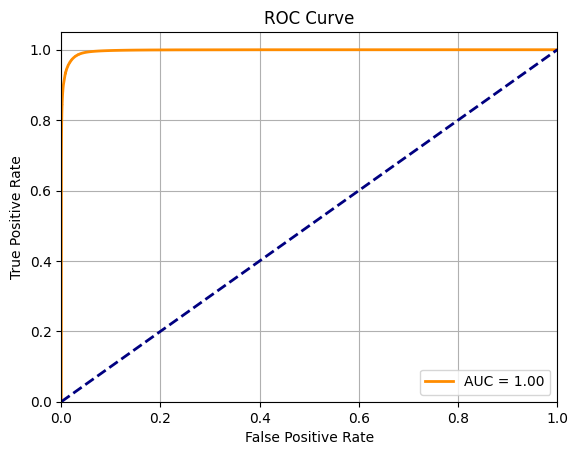

In [25]:
plot_roc_curve(Y_test, y_pred_all)

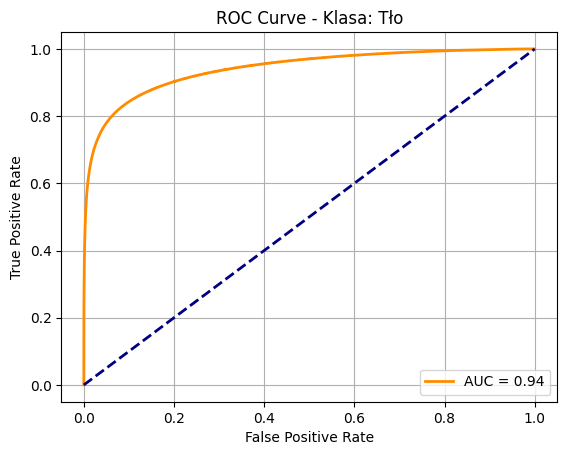

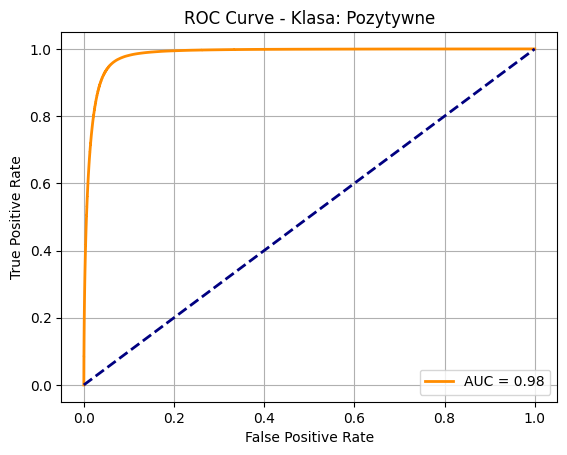

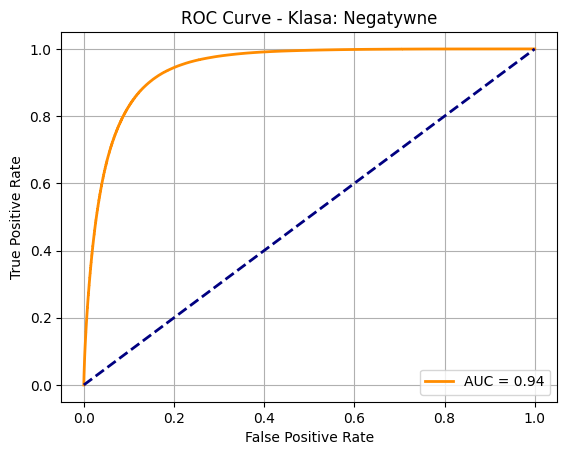

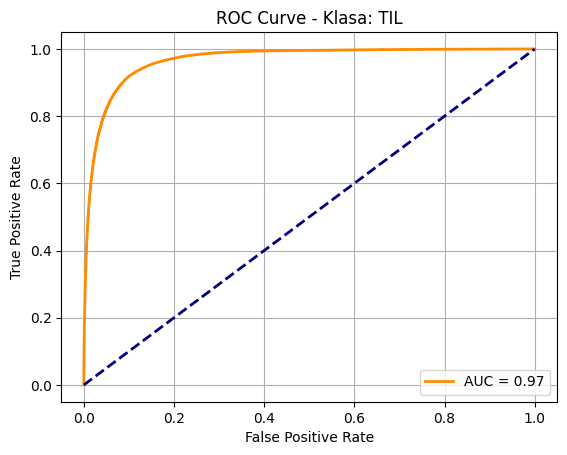

In [26]:
def plot_roc_for_class(y_true, y_score, class_index, class_name='Pozytywne'):
    y_true_class = y_true[..., class_index].flatten()
    y_score_class = y_score[..., class_index].flatten()

    fpr, tpr, _ = roc_curve(y_true_class, y_score_class)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - Klasa: {class_name}')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()

for i, label_name in enumerate(["Tło", "Pozytywne", "Negatywne", "TIL"]):
    plot_roc_for_class(Y_test, y_pred_all, class_index=i, class_name=label_name)

